In [1]:
import os
import pydicom
from PIL import Image
import numpy as np
import tensorflow as tf
import logging
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

logging.basicConfig(level=logging.INFO)


In [2]:
def load_dicom_image(path, img_size=256, use_rgb=False):
    try:
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array
        image = Image.fromarray(image)
        image = image.resize((img_size, img_size))
        image = np.array(image) / 255.0  # Normalize the image
        return tf.convert_to_tensor(image, dtype=tf.float32)
    except Exception as e:
        logging.error(f"Failed to process image {path}: {e}")
        return None


In [3]:
def process_patient_images(patient_folder, img_size=256):
    images = []
    try:
        for filename in os.listdir(patient_folder):
            if filename.endswith('.dcm'):
                path = os.path.join(patient_folder, filename)
                image = load_dicom_image(path, img_size=img_size)
                if image is not None:
                    images.append(image)
    except Exception as e:
        logging.warning(f"Error processing folder {patient_folder}: {e}")
    return images

In [4]:
import os

def collect_images_and_labels(root_dir, img_size=256):
    all_images = []
    all_labels = []
    conditions = {'cancer': 1, 'non_cancer': 0}  # Update as per your folder names

    def process_directory(directory, label):
        # Traverse the directory recursively
        for entry in os.listdir(directory):
            path = os.path.join(directory, entry)
            if os.path.isdir(path):
                process_directory(path, label)  # Recursive call for subdirectories
            elif entry.endswith('.dcm'):
                # Process this file if it's a DICOM file (assuming flat structure inside final folders)
                image = load_dicom_image(path, img_size)
                if image is not None:
                    all_images.append(image)
                    all_labels.append(label)

    for condition, label in conditions.items():
        condition_path = os.path.join(root_dir, condition)
        if os.path.isdir(condition_path):
            process_directory(condition_path, label)  # Start the recursive processing

    return all_images, all_labels


In [5]:
# Example of how to use the collect_images_and_labels
root_dir = '/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/new_train_data'
images, labels = collect_images_and_labels(root_dir)

2024-04-18 19:25:35.193716: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-18 19:25:35.193749: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-04-18 19:25:35.193756: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-04-18 19:25:35.193784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 19:25:35.193805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
import numpy as np

print("Images shape:", np.array(images).shape)
print("Labels shape:", np.array(labels).shape)

Images shape: (14527, 256, 256)
Labels shape: (14527,)


In [7]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
images_train_tensor = tf.convert_to_tensor(images_train)
images_test_tensor = tf.convert_to_tensor(images_test)
images_train_tensor_1 = images_train_tensor[:10]

In [8]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Flatten(),
      layers.Dense(10000, activation='relu'),
      layers.Dense(5000, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(5000, activation='relu'),
      layers.Dense(10000, activation='relu'),
      layers.Dense(64*64*8, activation='relu'),
      layers.Reshape((64,64,8)),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = images_test_tensor.shape[1:]
latent_dim = 1000
autoencoder = Autoencoder(latent_dim, shape)

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
autoencoder.fit(images_train_tensor, images_train_tensor,
                epochs=10,
                shuffle=True,
                validation_data=(images_test_tensor, images_test_tensor))

Epoch 1/10


2024-04-18 19:24:54.193103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 24/364 ━━━━━━━━━━━━━━━━━━━━ 5:08 906ms/step - loss: 0.2040

In [41]:
encoded_imgs = autoencoder.encoder(images_train_tensor_1).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
type(decoded_imgs)

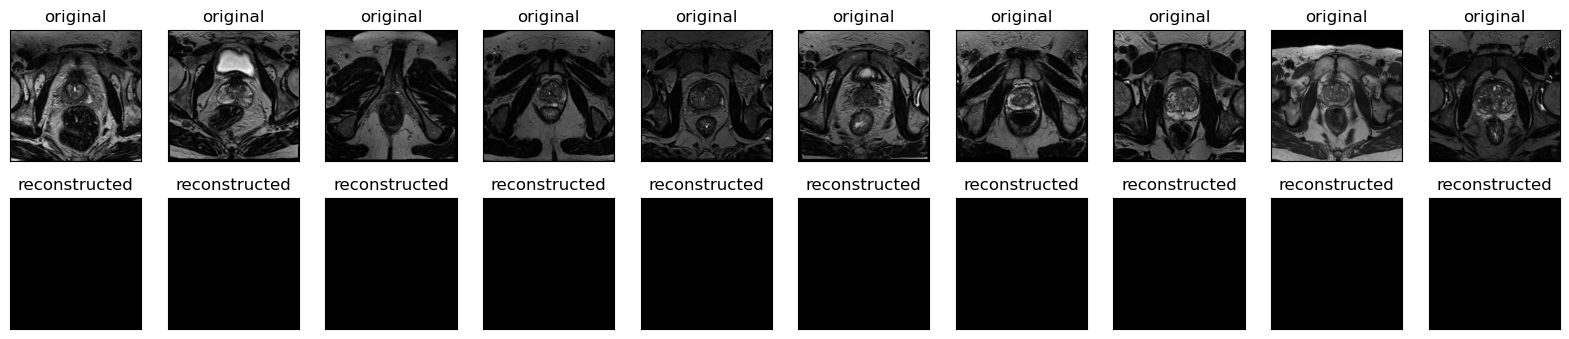

In [42]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images_test_tensor[i].numpy() * 255, cmap='gray', vmin=0, vmax=255)
    plt.title("original")
    plt.axis('off')  # Hide axes for clarity

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i] * 255, cmap='gray', vmin=0, vmax=255)
    plt.title("reconstructed")
    plt.axis('off')
plt.show()


In [ ]:
latent_representations = autoencoder.encoder.predict(images_train_tensor)  # Generate latent representations

# Save the latent representations
np.save('latent_representations.npy', latent_representations)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# Load latent representations
latent_representations = np.load('latent_representations.npy')

# Define a new model that uses the latent representations
input_latent = Input(shape=(32,))
x = Dense(64, activation='relu')(input_latent)
output = Dense(1, activation='sigmoid')(x)  
model = Model(input_latent, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

